# Client orders :: *ipynb solution draft* <br>

## Read Data

In [1]:
# Import libraries

import order_functions as of

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from persiantools import jdatetime

from scipy.stats import boxcox
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("sales_data_clean.csv")
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,1396-10-26,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,1394-04-21,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,1402-05-24,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,1397-06-17,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,1392-09-30,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


In [3]:
# Convert Shamsi dates to Miladi

def vectorized_convert_shamsi_to_datetime(years, months, days):
    gregorian_dates = [
        jdatetime.JalaliDate(int(y), int(m), int(d)).to_gregorian()
        for y, m, d in zip(years, months, days)
    ]
    return pd.to_datetime(gregorian_dates)

years, months, days = zip(*df["Order_Date"].str.split("-").tolist())
df["Order_Date"] = vectorized_convert_shamsi_to_datetime(years, months, days)
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,2018-01-16,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,2015-07-12,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,2023-08-15,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,2018-09-08,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,2013-12-21,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


---

## Client Order #1

شرکت می‌خواهد برای افزایش مشتریان خود بودجه‌ای را به بحث تبلیغات اختصاص دهد و از شما می‌خواهد از بین شهر‌هایی که در آن نمایندگی دارد، شهر‌هایی را که برای این امر مناسب‌تر هستند معرفی کنید.

In [4]:
# Filter coumns needed for analyze

cols_for_analyze_1 = [
    "Order_ID",
    "Branch",
    "Order_Date",
    "Price",
    "Quantity",
    "Discount",
    "Total_Price",
    "Profit",
    "Ship_Duration",
]
df1 = df[cols_for_analyze_1].copy()

df1.head()

,Order_ID,Branch,Order_Date,Price,Quantity,Discount,Total_Price,Profit,Ship_Duration
0,0,Hamedan,2018-01-16,3450000,1,0,3450000,250000,3
1,1,Kermanshah,2015-07-12,3400000,1,0,3400000,380000,2
2,2,Rasht,2023-08-15,44900000,1,0,44900000,5630000,5
3,3,Kermanshah,2018-09-08,12550000,1,0,12550000,1130000,3
4,4,Karaj,2013-12-21,2050000,1,0,2050000,180000,8


In [5]:
# Add columns 'Year'
df1["Year"] = df1["Order_Date"].dt.year

# Add column AOV: Average Order Value
df1["AOV"] = df1["Total_Price"] / df1["Quantity"]

In [6]:
# Year_Over_Year (YOY) growth for each branch over the years

df1_yoy = df1.groupby(["Year", "Branch"]).agg({"Total_Price": "sum"}).reset_index()
df1_yoy = df1_yoy.pivot(index="Branch", columns="Year", values="Total_Price")
df1_yoy_sorted = df1_yoy.sort_values(by=df1["Year"].max(), ascending=False)

df1_yoy_sorted

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Branch,,,,,,,,,,,,,
Tehran,1905905498,31782216485,47019754481,46618385973,47860596985,50346519484,56636741976,124081894956,179752035444,293560423951,365025622478,419390878479,539215676970
Mashhad,1286458999,21258172495,31458145988,30546132486,31717673988,34100884484,37426385484,81646120464,120009271465,191659601460,244174091982,277491354975,365323838977
Isfahan,1282254498,21110042496,31295810489,30195051986,32498104987,34199560986,36982528986,80646395972,121020124469,193872793967,247182288979,277210619977,364541763987
Sari,624979500,10395736993,15710998992,15724489994,16305011994,16890752994,18002522984,40109235981,59870213475,99338412986,120977806986,138097283991,185528869995
Kish,601746500,10202313496,15802794994,14990876998,16358918492,16699741993,18705003997,40495086981,59664163485,95541741481,122104673993,141134346494,184830274493
Zanjan,686487500,10744646497,15992562991,15131929995,16228959495,16713323993,18325783492,40452171983,58300419979,97007168489,120809055487,139675005493,183155313992
Shiraz,619780999,10718069999,15836082495,15476597490,16164177495,16904595992,18681609499,41285716986,59559447979,98232864985,119739284487,141091728492,183120822487
Yazd,694035000,10397363497,15710536492,15110385496,16319027493,17272952992,18663532489,40871504978,58929858475,97178060486,121473424494,137440780492,183104780992
Rasht,642398000,10421519497,15951619490,14939089994,16173311492,17231713498,18474273993,40096124483,60315843481,98605518990,124020442992,143394917492,180930126989


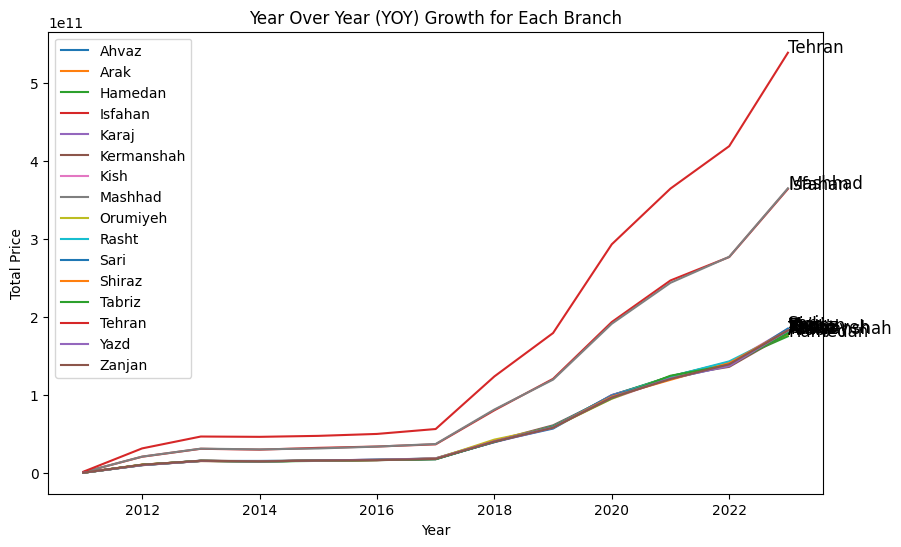

In [7]:
# YOY growth plot for each branch over the years

fig, ax = plt.subplots(figsize=(10, 6))
for branch in df1_yoy.index:
    ax.plot(df1_yoy.columns, df1_yoy.loc[branch], label=branch)
    ax.text(
        df1_yoy.columns[-1], df1_yoy.loc[branch, df1["Year"].max()], branch, fontsize=12
    )
ax.set_title("Year Over Year (YOY) Growth for Each Branch")
ax.set_xlabel("Year")
ax.set_ylabel("Total Price")
ax.legend()
plt.show()

In [8]:
# Extract key indexes for each branch

city_data = (
    df1.groupby("Branch")
    .agg(
        total_orders=pd.NamedAgg(column="Order_ID", aggfunc="count"),
        total_profit=pd.NamedAgg(column="Profit", aggfunc="sum"),
        avg_discount=pd.NamedAgg(column="Discount", aggfunc="mean"),
        avg_profit=pd.NamedAgg(column="Profit", aggfunc="mean"),
        avg_aov=pd.NamedAgg(column="AOV", aggfunc="mean"),
    )
    .reset_index()
)

city_data["yoy"] = df1_yoy.iloc[:, -1].values

city_data

,Branch,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Ahvaz,50793,73179880000,0.601677,1.440747e+06,1.300790e+07,179796886989
1,Arak,50915,73322370000,0.603260,1.440094e+06,1.310881e+07,177905378988
2,Hamedan,50984,73304140000,0.603464,1.437787e+06,1.304174e+07,175609979491
3,Isfahan,101698,146746110000,0.604673,1.442960e+06,1.312369e+07,364541763987
4,Karaj,51078,73290360000,0.591116,1.434871e+06,1.303892e+07,180780317991
5,Kermanshah,50904,73213100000,0.598067,1.438258e+06,1.303609e+07,179713147989
6,Kish,50747,73430860000,0.607267,1.446999e+06,1.313472e+07,184830274493
7,Mashhad,101684,146242020000,0.603477,1.438201e+06,1.304930e+07,365323838977
8,Orumiyeh,50914,73123930000,0.607750,1.436224e+06,1.307974e+07,180245385994
9,Rasht,50851,73780300000,0.602623,1.450911e+06,1.316426e+07,180930126989


In [9]:
# Create sorted table of branches in each key index

top_n = 16
top_df = pd.DataFrame()

for col in city_data.columns:
    if col != "Branch":
        top_df[col] = city_data.nlargest(top_n, col)["Branch"].values
top_df

,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Tehran,Tehran,Sari,Rasht,Rasht,Tehran
1,Isfahan,Isfahan,Shiraz,Sari,Kish,Mashhad
2,Mashhad,Mashhad,Orumiyeh,Kish,Isfahan,Isfahan
3,Karaj,Rasht,Kish,Isfahan,Sari,Sari
4,Hamedan,Sari,Yazd,Zanjan,Arak,Kish
5,Shiraz,Shiraz,Tabriz,Shiraz,Shiraz,Zanjan
6,Arak,Kish,Isfahan,Yazd,Zanjan,Shiraz
7,Orumiyeh,Arak,Mashhad,Ahvaz,Orumiyeh,Yazd
8,Kermanshah,Hamedan,Hamedan,Arak,Tehran,Rasht
9,Rasht,Karaj,Arak,Tehran,Tabriz,Karaj


In [10]:
# Create Rank table of branches in each key index

rank_df = city_data.copy()
for column in top_df.columns:
    rank_df[column] = city_data[column].rank().astype(int)

rank_df

,Branch,total_orders,total_profit,avg_discount,avg_profit,avg_aov,yoy
0,Ahvaz,4,4,5,9,1,5
1,Arak,10,9,7,8,12,2
2,Hamedan,12,8,8,3,5,1
3,Isfahan,15,15,10,13,14,14
4,Karaj,13,7,1,1,4,7
5,Kermanshah,8,6,3,5,3,4
6,Kish,2,10,13,14,15,12
7,Mashhad,14,14,9,4,6,15
8,Orumiyeh,9,3,14,2,9,6
9,Rasht,7,13,6,16,16,8


### Rationale:
We have two types of market ahead:
- Established:
    with strong market presence: High Orders, High Profits & High Year-Over-Year-Growth
- Emerging:
    with more growth potential > Marketable: High Average Discount, High Average Order Value & High Year-Over-Year-Growth

In [11]:
# Established Market Weights
alpha_e = 0.5   # Total Orders
beta_e = 0.4    # Total Profit
gamma_e = 0.1   # YOY Growth of Last Year

# Emerging Market Weights
alpha_m = 0.4   # Average Discount Rate
beta_m = 0.4    # Average Order of Value
gamma_m = 0.2   # YOY Growth of Last Year

In [12]:
# Calculate score for each branch by market type

score_df = rank_df.copy()

score_df["Established Score"] = (
    alpha_e * score_df["total_orders"]
    + beta_e * score_df["total_profit"]
    + gamma_e * score_df["yoy"]
)

score_df["Emerging Score"] = (
    alpha_m * score_df["avg_discount"]
    + beta_m * score_df["avg_aov"]
    + gamma_m * score_df["yoy"]
)

established_cities = score_df[["Branch", "Established Score"]].sort_values(
    by="Established Score", ascending=False
)
emerging_cities = score_df[["Branch", "Emerging Score"]].sort_values(
    by="Emerging Score", ascending=False
)

In [13]:
established_cities

,Branch,Established Score
13,Tehran,16.0
3,Isfahan,14.9
7,Mashhad,14.1
11,Shiraz,10.9
4,Karaj,10.0
9,Rasht,9.5
2,Hamedan,9.3
10,Sari,9.1
1,Arak,8.8
5,Kermanshah,6.8


In [14]:
emerging_cities

,Branch,Emerging Score
10,Sari,14.2
6,Kish,13.6
3,Isfahan,12.4
11,Shiraz,12.4
8,Orumiyeh,10.4
9,Rasht,10.4
7,Mashhad,9.0
1,Arak,8.0
13,Tehran,8.0
12,Tabriz,7.8


### Result
Choose two from either:
- Top branches in established market: **Tehran** & **Isfahan**
- Top branched in emerging market: **Sari** & **kish**

*Hint:* <br>
    **Isfahan** & **Shiraz** are in top five of both markets and they seem to be promising!

<br>

> Cities for furthur advertisement: <br>
> **Tehran**, **Isfahan**, **Sari**, **Kish**, **Shiraz**

---